# Object detection with Pytorch

## About this Notebook

I am just trying to get a feeling for object detection using PyTorch and a Region Proposal Network approach (Faster R-CNN in this case).  Also setup a working baseline system, with the right python environments and dependancies for validation and training visualisation for future use on more specific projects.

### TODO:

1. Understand some of the dependencies and remove them if they are unnecessary.
2. Setup Tensorboard so I can look at the training outcomes in detail.
3. Modify so model weights are saved only when the validation loss improves.
4. Create some visualisations of the model performance on the test set.
5. Look into the NN architecture and make some notes about sensible image sizes.
6. Extend to a segmentation step
7. Move on to my YOLO implementation so I can compare the two with similar tools and approaches.
8. Consider strategies for large raster/image files with small objects, more typical in remote sensing.

## Setup
VScode: Set up a workspace, ctrl-shift-T to open bash, move to the working directory
Create a Conda Environment including: Pytorch, TorchVision, CudaToolkit, cython, pycocotools, matplotlib & pandas

Cython, pycocotools, matplotlib are needed to use the liraries in the pytorch/vision/references/detection/ github repository

Note that I got cuda errors using cudatoolkit 11.1 & Numpy 1.19.1 I haven't investigate which of these versions was the issue but the original notes I followed suggested using numpy 1.17

%%bash

%% conda update conda <br>
%% conda create -n detection python=3.8.6 <br>
%% conda activate detection <br>
%% conda install numpy=1.17 pytorch torchvision cudatoolkit=10.1 -c pytorch <br>
%% conda install ipykernel -y <br>
%% conda install cython matplotlib pandas <br>
%% conda install pycocotools <br>

Then run the cell below to see if PyTorch is available and the GPU is getting used.

In [1]:
# Create a sub-directory if it doesn't exist and add it to the python path.
import sys, os
from pathlib import Path

cwd = Path(os.getcwd())
vis_libs = cwd / 'required_libraries'   # storing as filepath object for convenience
dataset_pth = cwd / 'raccoon_dataset'

if not os.path.exists(vis_libs):
            os.makedirs(vis_libs)

if not vis_libs in sys.path:
    sys.path.append(str(vis_libs))   #sys.path takes strings not filepath objects

print('Current working diretory:', cwd )
print('Additional libraries located in:', str(vis_libs) )
print('Image dataset located in:', str(dataset_pth) )
#print('System paths:', sys.path)

Current working diretory: /home/olly/Documents/Data_Science/object_detection
Additional libraries located in: /home/olly/Documents/Data_Science/object_detection/required_libraries
Image dataset located in: /home/olly/Documents/Data_Science/object_detection/raccoon_dataset


In [2]:
# Check things are running nicely

import torchvision
from torchvision import torch
import pycocotools

#os.chdir("<your path>/pytorch object detection")  #Shouldn't need this if already in object_detection from VS_code terminal
#device = 'cpu'  # Force device to CPU for trouble-shooting only (better error messages)
#device = torch.device("cpu")

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

Setup complete. Using torch 1.7.1 _CudaDeviceProperties(name='GeForce GTX 1060', major=6, minor=1, total_memory=6078MB, multi_processor_count=10)


In bash terminal, clone the Racoon dataset, and the vision repository, then copy the transforms.py, coco_eval.py, engine.py and coco_utils.py libraries to the required_libraries sub-directory, then return to the working directory.

%% git clone https://github.com/experiencor/raccoon_dataset.git <br> 
%% git clone https://github.com/pytorch/vision.git<br>

%% cd ./vision <br>

%% git checkout v0.3.0<br>
%%  references/detection/utils.py ../required_libraries <br>
%% cp references/detection/transforms.py ../required_libraries <br>
%% cp references/detection/coco_eval.py ../required_libraries <br>
%% cp references/detection/engine.py ../required_libraries <br>
%% cp references/detection/coco_utils.py ../required_libraries<br>
%% cd ..


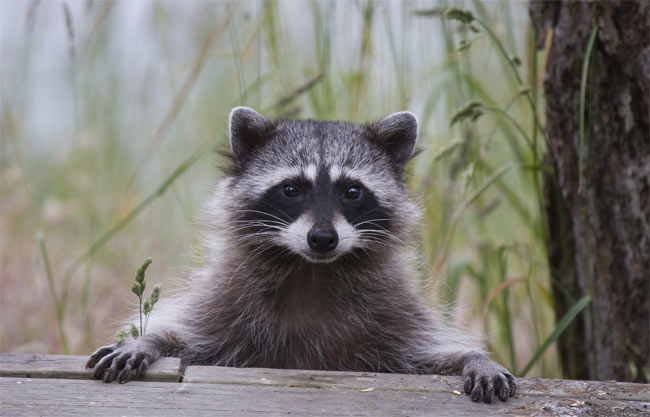

In [3]:
# Taking a look at an image from the dataset
from PIL import Image
image = Image.open("./raccoon_dataset/images/raccoon-1.jpg")
image

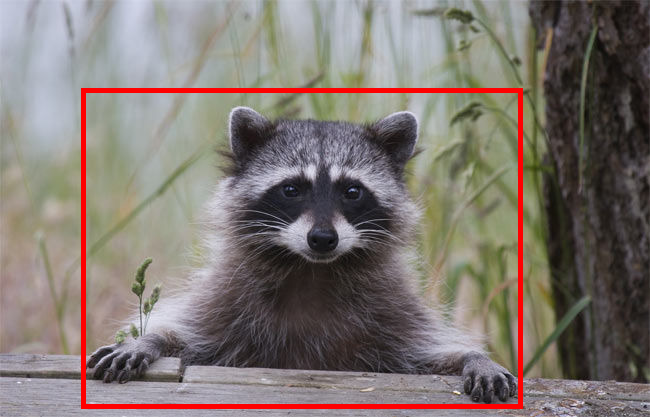

In [4]:
#  Checking out an example of the annotation file
from PIL import ImageDraw

xmin = 81
ymin = 88
xmax = 522
ymax = 408
draw = ImageDraw.Draw(image)
draw.rectangle([(xmin, ymin), (xmax, ymax)], outline ='red', width=5)
image

In [5]:
#Now taking a look at the label csv file
 
import pandas as pd
labels = pd.read_csv('./raccoon_dataset/data/raccoon_labels.csv')
labels.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,raccoon-1.jpg,650,417,raccoon,81,88,522,408
1,raccoon-10.jpg,450,495,raccoon,130,2,446,488
2,raccoon-100.jpg,960,576,raccoon,548,10,954,520
3,raccoon-101.jpg,640,426,raccoon,86,53,400,356
4,raccoon-102.jpg,259,194,raccoon,1,1,118,152


In [6]:
import numpy as np
import torch
import torch.utils.data
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# The following imports are training libraries specific to object detection that were earlier cloned from the github repo

from engine import train_one_epoch, evaluate
import utils
import transforms as T


In [7]:
# Create a helper fuction to take the csv annotation file and create an array with that inherets from the torch.utils.data.Dataset class Specifically it needs to implement the __getitem__ and __len__ methods)

def parse_one_annot(path_to_data_file, filename):
   data = pd.read_csv(path_to_data_file)
   boxes_array = data[data["filename"] == filename][["xmin", "ymin","xmax", "ymax"]].values
   
   return boxes_array

# Write the RaccoonDataset class:

class RaccoonDataset(torch.utils.data.Dataset):
    def __init__(self, root, data_file, transforms=None):
        self.root = root
        self.transforms = transforms
        self.imgs = sorted(os.listdir(os.path.join(root, "images")))
        self.path_to_data_file = data_file

    def __getitem__(self, idx):
        # load images and bounding boxes
        img_path = os.path.join(self.root, "images", self.imgs[idx])
        img = Image.open(img_path).convert("RGB")
        box_list = parse_one_annot(self.path_to_data_file, self.imgs[idx])
        boxes = torch.as_tensor(box_list, dtype=torch.float32)  
        num_objs = len(box_list)

        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:,0])

        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)
        
        return img, target

    def __len__(self):
        return len(self.imgs)

In [8]:
 #Check the dataset is implemeted correctly by trying the getitem method on the first image.
print(str(dataset_pth / "raccoon_labels.csv"))

annotations_pth = dataset_pth / "data" / "raccoon_labels.csv"
dataset = RaccoonDataset(root= str(dataset_pth), data_file= str(annotations_pth))

dataset.__getitem__(0)



/home/olly/Documents/Data_Science/object_detection/raccoon_dataset/raccoon_labels.csv


(<PIL.Image.Image image mode=RGB size=650x417 at 0x7FBA614D4A60>,
 {'boxes': tensor([[ 81.,  88., 522., 408.]]),
  'labels': tensor([1]),
  'image_id': tensor([0]),
  'area': tensor([141120.]),
  'iscrowd': tensor([0])})

Download a pre-trained model , trained on COCO [Choosing R-CNN ResNet-50 FPN](https://arxiv.org/abs/1506.01497) or [Mask R-CNN ResNet-50 FPN] (https://arxiv.org/abs/1703.06870).  The mask R-CNN has an extra branch that can be used for image segmentation.

In [9]:
# Download a pre-trained model (Choosing R-CNN ResNet-50 FPN)

def get_model(num_classes):
   # load an object detection model pre-trained on COCO
   model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
   
   # get the number of input features for the classifier
   in_features = model.roi_heads.box_predictor.cls_score.in_features
   
   # replace the pre-trained head with a new on
   model.roi_heads.box_predictor = FastRCNNPredictor(in_features,num_classes)
   
   return model

In [10]:
# Set up some data augmentation
def get_transform(train):
   transforms = []
   # converts the image, a PIL image, into a PyTorch Tensor
   transforms.append(T.ToTensor())
   if train:
      # during training, randomly flip the training images
      # and ground-truth for data augmentation
      transforms.append(T.RandomHorizontalFlip(0.5))
   return T.Compose(transforms)

In [11]:
# our dataset has two classes only - raccoon and not racoon
num_classes = 2
# get the model using our helper function
model = get_model(num_classes)
# move model to the right device
model.to(device)
# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)
# and a learning rate scheduler which decreases the learning rate by # 10x every 3 epochs

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=3,gamma=0.1)

In [12]:
# use our dataset and defined transformations

dataset = RaccoonDataset(root= str(dataset_pth),
               data_file= str(annotations_pth),
          transforms = get_transform(train=True))

dataset_test = RaccoonDataset(root= str(dataset_pth),
               data_file= str(annotations_pth),
               transforms = get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)   # note this bit only works with CUDA
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-40])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-40:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
              dataset, batch_size=2, shuffle=True, num_workers=4,
              collate_fn=utils.collate_fn)
              
data_loader_test = torch.utils.data.DataLoader(
         dataset_test, batch_size=1, shuffle=False, num_workers=4,
         collate_fn=utils.collate_fn)
         
print("We have: {} examples, {} are training and {} testing".format(len(indices), len(dataset), len(dataset_test)))

We have: 200 examples, 160 are training and 40 testing


** Training the model **

In [13]:
# For reference:  the device was defined up near the top with:
# device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - raccoon and not racoon
num_classes = 2
# get the model using our helper function
model = get_model(num_classes)
# move model to the right device
model.to(device)
# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
                            
# and a learning rate scheduler which decreases the learning rate by # 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

#print(model)

In [14]:
# Now write a training loop

num_epochs = 15  #increase when working
for epoch in range(num_epochs):
   # train for one epoch, printing every 10 iterations
   train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10) 
   # update the learning rate
   lr_scheduler.step()
   # evaluate on the test dataset
   #evaluate(model, data_loader_test, device=device)

0704)  loss_classifier: 0.0200 (0.0210)  loss_box_reg: 0.0339 (0.0419)  loss_objectness: 0.0004 (0.0006)  loss_rpn_box_reg: 0.0041 (0.0068)  time: 0.9363  data: 0.0027  max mem: 4032
Epoch: [6]  [30/80]  eta: 0:00:48  lr: 0.000050  loss: 0.0581 (0.0656)  loss_classifier: 0.0194 (0.0194)  loss_box_reg: 0.0274 (0.0374)  loss_objectness: 0.0004 (0.0009)  loss_rpn_box_reg: 0.0057 (0.0079)  time: 0.9756  data: 0.0035  max mem: 4032
Epoch: [6]  [40/80]  eta: 0:00:38  lr: 0.000050  loss: 0.0581 (0.0656)  loss_classifier: 0.0154 (0.0192)  loss_box_reg: 0.0274 (0.0367)  loss_objectness: 0.0004 (0.0010)  loss_rpn_box_reg: 0.0075 (0.0087)  time: 0.9862  data: 0.0036  max mem: 4032
Epoch: [6]  [50/80]  eta: 0:00:28  lr: 0.000050  loss: 0.0637 (0.0661)  loss_classifier: 0.0167 (0.0200)  loss_box_reg: 0.0309 (0.0362)  loss_objectness: 0.0008 (0.0011)  loss_rpn_box_reg: 0.0076 (0.0088)  time: 0.9634  data: 0.0038  max mem: 4032
Epoch: [6]  [60/80]  eta: 0:00:19  lr: 0.000050  loss: 0.0563 (0.0650)  l

In [15]:
# Save out the model weights in a sensible location

model_weight_dir = cwd / 'pt_models'
raccoon_wt = model_weight_dir / 'model_wt'

if not os.path.exists(model_weight_dir):
            os.makedirs(str(model_weight_dir))

torch.save(model.state_dict(), str(raccoon_wt))

print('Model weights saved to:', str(raccoon_wt))


Model weights saved to: /home/olly/Documents/Data_Science/object_detection/pt_models/model_wt


**The inference steps**

In [16]:
# Load up the model and model weights
loaded_model = get_model(num_classes = 2)
loaded_model.load_state_dict(torch.load(str(raccoon_wt)))

<All keys matched successfully>

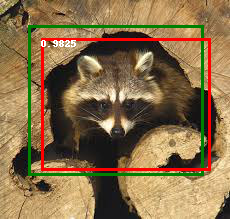

In [17]:
idx = 13
img, _ = dataset_test[idx]
label_boxes = np.array(dataset_test[idx][1]["boxes"])

#put the model in evaluation mode
loaded_model.eval()

with torch.no_grad():
   prediction = loaded_model([img])
   image = Image.fromarray(img.mul(255).permute(1, 2,0).byte().numpy())
draw = ImageDraw.Draw(image)

# draw groundtruth

for elem in range(len(label_boxes)):
   draw.rectangle([(label_boxes[elem][0], label_boxes[elem][1]),
   (label_boxes[elem][2], label_boxes[elem][3])], 
   outline ="green", width =3)
   
for element in range(len(prediction[0]["boxes"])):
   boxes = prediction[0]["boxes"][element].cpu().numpy()
   score = np.round(prediction[0]["scores"][element].cpu().numpy(),
                    decimals= 4)
   if score > 0.8:
      draw.rectangle([(boxes[0], boxes[1]), (boxes[2], boxes[3])], 
      outline ="red", width =3)
      draw.text((boxes[0], boxes[1]), text = str(score))
image